In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import keras
import tensorflow
import xgboost as xgb
import lightgbm as lgb

## Loading data and initial EDA

In [2]:
df = pd.read_parquet("training_data.parquet")

In [3]:
df.head()

date symbol       revenue  costOfRevenue   grossProfit  \
0  2023-09-29   AAPL  383285000000   214137000000  169148000000   
1  2022-09-23   AAPL  394328000000   223546000000  170782000000   
2  2021-09-24   AAPL  365817000000   212981000000  152836000000   
3  2020-09-25   AAPL  274515000000   169559000000  104956000000   
4  2022-12-30   META  116609000000    25249000000   91360000000   

   grossProfitRatio  researchAndDevelopmentExpenses  \
0          0.441311                    2.991500e+10   
1          0.433096                    2.625100e+10   
2          0.417794                    2.191400e+10   
3          0.382332                    1.875200e+10   
4          0.783473                    3.533800e+10   

   generalAndAdministrativeExpenses  sellingAndMarketingExpenses  \
0                                 0                            0   
1                                 0                            0   
2                                 0                            0   
3                                 0                            0   
4                       11816000000                  15262000000   

   sellingGeneralAndAdministrativeExpenses  ...  \
0                              24932000000  ...   
1                              25094000000  ...   
2                              21973000000  ...   
3                              19916000000  ...   
4                              27078000000  ...   

   netCashUsedProvidedByFinancingActivities  effectOfForexChangesOnCash  \
0                             -108488000000                           0   
1                             -110749000000                           0   
2                              -93353000000                           0   
3                              -86820000000                           0   
4                              -22136000000                  -638000000   

   netChangeInCash  cashAtEndOfPeriod  cashAtBeginningOfPeriod  \
0       5760000000        30737000000              24977000000   
1     -10952000000        24977000000              35929000000   
2      -3860000000        35929000000              39789000000   
3     -10435000000        39789000000              50224000000   
4      -1269000000        15596000000              16865000000   

   operatingCashFlow  capitalExpenditure  freeCashFlow      marketCap  target  
0       110543000000        -10959000000   99584000000  2670779095140     1.0  
1       122151000000        -10708000000  111443000000  2411450364260     1.0  
2       104038000000        -11085000000   92953000000  2422287817320     0.0  
3        80674000000         -7309000000   73365000000  1915229798160     1.0  
4        50475000000        -31431000000   19044000000   317456920000     1.0  

[5 rows x 103 columns]

In [4]:
df.shape

(300, 103)

In [5]:
df.drop(["date", "symbol"], axis=1, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Columns: 101 entries, revenue to target
dtypes: float64(12), int64(89)
memory usage: 236.8 KB


In [7]:
df.describe()

revenue  costOfRevenue   grossProfit  grossProfitRatio  \
count  3.000000e+02   3.000000e+02  3.000000e+02        300.000000   
mean   2.200315e+11   1.489912e+11  6.805929e+10          0.498853   
std    1.120280e+12   8.161136e+11  3.062465e+11          0.268093   
min    2.647480e+08   0.000000e+00 -1.299500e+10         -0.071977   
25%    1.451400e+10   2.094059e+09  4.031100e+09          0.292798   
50%    3.520700e+10   1.182600e+10  1.552550e+10          0.501802   
75%    1.032270e+11   5.522325e+10  4.006850e+10          0.685313   
max    1.153984e+13   8.398931e+12  3.140906e+12          1.000000   

       researchAndDevelopmentExpenses  generalAndAdministrativeExpenses  \
count                    3.000000e+02                      3.000000e+02   
mean                     1.168245e+10                      2.583912e+10   
std                      6.978738e+10                      1.501308e+11   
min                      0.000000e+00                      0.000000e+00   
25%                      0.000000e+00                      1.378098e+08   
50%                      3.470575e+08                      2.084500e+09   
75%                      2.476250e+09                      7.551750e+09   
max                      7.356980e+11                      1.578039e+12   

       sellingAndMarketingExpenses  sellingGeneralAndAdministrativeExpenses  \
count                 3.000000e+02                             3.000000e+02   
mean                  7.776916e+09                             3.757750e+10   
std                   3.964152e+10                             1.888293e+11   
min                  -2.000000e+08                             1.825460e+08   
25%                   0.000000e+00                             2.008250e+09   
50%                   3.370000e+08                             6.125000e+09   
75%                   3.211087e+09                             2.074950e+10   
max                   3.911310e+11                             1.969170e+12   

       otherExpenses  operatingExpenses  ...  \
count   3.000000e+02       3.000000e+02  ...   
mean   -1.721630e+08       4.206091e+10  ...   
std     1.262662e+10       1.873433e+11  ...   
min    -7.136500e+10      -6.559400e+10  ...   
25%    -2.225000e+06       2.280850e+09  ...   
50%     6.065000e+07       9.065500e+09  ...   
75%     1.292000e+09       3.068755e+10  ...   
max     6.703900e+10       1.957149e+12  ...   

       netCashUsedProvidedByFinancingActivities  effectOfForexChangesOnCash  \
count                              3.000000e+02                3.000000e+02   
mean                               2.051772e+09                5.073596e+08   
std                                7.253561e+10                7.934250e+09   
min                               -3.365780e+11               -2.164300e+10   
25%                               -8.871000e+09               -1.040000e+08   
50%                               -1.908190e+09               -1.600000e+04   
75%                                6.985360e+08                5.825000e+06   
max                                6.669670e+11                9.436900e+10   

       netChangeInCash  cashAtEndOfPeriod  cashAtBeginningOfPeriod  \
count     3.000000e+02       3.000000e+02             3.000000e+02   
mean      2.779227e+09       5.355923e+10             5.077993e+10   
std       5.031438e+10       2.116463e+11             2.093095e+11   
min      -5.687360e+11       5.200000e+07             4.300000e+07   
25%      -8.901355e+08       2.566425e+09             2.115864e+09   
50%       1.426380e+08       7.607126e+09             7.329000e+09   
75%       2.294737e+09       1.859425e+10             1.795400e+10   
max       2.716870e+11       2.049636e+12             2.049636e+12   

       operatingCashFlow  capitalExpenditure  freeCashFlow     marketCap  \
count       3.000000e+02        3.000000e+02  3.000000e+02  3.000000e+02   
mean        2.968446e+10       -1.162071e+10  1.806373e+10  2.429

In [8]:
print(f"Count of NULL values: {df.isnull().sum().sum()}")

Count of NULL values: 0


In [9]:
df.columns

Index(['revenue', 'costOfRevenue', 'grossProfit', 'grossProfitRatio',
       'researchAndDevelopmentExpenses', 'generalAndAdministrativeExpenses',
       'sellingAndMarketingExpenses',
       'sellingGeneralAndAdministrativeExpenses', 'otherExpenses',
       'operatingExpenses',
       ...
       'netCashUsedProvidedByFinancingActivities',
       'effectOfForexChangesOnCash', 'netChangeInCash', 'cashAtEndOfPeriod',
       'cashAtBeginningOfPeriod', 'operatingCashFlow', 'capitalExpenditure',
       'freeCashFlow', 'marketCap', 'target'],
      dtype='object', length=101)

In [10]:
df["target"].value_counts()

target
1.0    193
0.0    107
Name: count, dtype: int64

## Preparing data for modelling

In [11]:
X = df.drop(["target"], axis=1)
y = df["target"]

print(X.shape)
print(y.shape)

(300, 100)
(300,)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
results = {}

## Logistic regression

In [14]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression())
])

In [15]:
param_grid = [
    {
        "logreg__solver": ["lbfgs", "sag"],
        "logreg__penalty": ("l2", None),
        "logreg__C": [0.1, 0.2, 0.5, 1, 2, 5, 10, 20]
    },
    {
        "logreg__solver": ["liblinear"],
        "logreg__penalty": ("l2", "l1"),
        "logreg__C": [0.1, 0.2, 0.5, 1, 2, 5, 10, 20]
    },
    {
        "logreg__solver": ["saga"],
        "logreg__penalty": ("elasticnet", "l2", "l1", None),
        "logreg__C": [0.1, 0.2, 0.5, 1, 2, 5, 10, 20]
    },
]

In [16]:
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring="accuracy")
grid.fit(X_train, y_train)

D:\Anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Anaconda\

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg', LogisticRegression())]),
             param_grid=[{'logreg__C': [0.1, 0.2, 0.5, 1, 2, 5, 10, 20],
                          'logreg__penalty': ('l2', None),
                          'logreg__solver': ['lbfgs', 'sag']},
                         {'logreg__C': [0.1, 0.2, 0.5, 1, 2, 5, 10, 20],
                          'logreg__penalty': ('l2', 'l1'),
                          'logreg__solver': ['liblinear']},
                         {'logreg__C': [0.1, 0.2, 0.5, 1, 2, 5, 10, 20],
                          'logreg__penalty': ('elasticnet', 'l2', 'l1', None),
                          'logreg__solver': ['saga']}],
             scoring='accuracy')

In [17]:
print(f"Best parameters: {grid.best_params_}")
print(f"Best testing score: {grid.best_score_}")

Best parameters: {'logreg__C': 0.2, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best testing score: 0.6875000000000001


In [18]:
y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test dataset score: {accuracy}")

results["Logistic Regression"] = accuracy

Test dataset score: 0.5333333333333333


## Support Vector Machines

In [19]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC())
])

In [20]:
param_grid = [
    {
        "svm__C": [0.1, 0.2, 0.5, 1, 2, 4, 8, 12, 16, 20],
        "svm__kernel": ["linear", "poly", "rbf", "sigmoid"]
    }
]

In [21]:
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring="accuracy")
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC())]),
             param_grid=[{'svm__C': [0.1, 0.2, 0.5, 1, 2, 4, 8, 12, 16, 20],
                          'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}],
             scoring='accuracy')

In [22]:
print(f"Best parameters: {grid.best_params_}")
print(f"Best testing score: {grid.best_score_}")

Best parameters: {'svm__C': 4, 'svm__kernel': 'rbf'}
Best testing score: 0.7083333333333333


In [23]:
y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test dataset score: {accuracy}")

results["SVM"] = accuracy

Test dataset score: 0.5833333333333334


## Decision Tree Classifier

In [24]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("tree", DecisionTreeClassifier())
])

In [25]:
param_grid = [
    {
        "tree__criterion": ["gini", "entropy", "log_loss"],
        "tree__max_depth": [4, 8, 12, 16, 20, 30, 40],
        "tree__ccp_alpha": [0, 0.5, 1, 1.5, 2, 2.5]
    }
]

In [26]:
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring="accuracy")
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('tree', DecisionTreeClassifier())]),
             param_grid=[{'tree__ccp_alpha': [0, 0.5, 1, 1.5, 2, 2.5],
                          'tree__criterion': ['gini', 'entropy', 'log_loss'],
                          'tree__max_depth': [4, 8, 12, 16, 20, 30, 40]}],
             scoring='accuracy')

In [27]:
print(f"Best parameters: {grid.best_params_}")
print(f"Best testing score: {grid.best_score_}")

Best parameters: {'tree__ccp_alpha': 0.5, 'tree__criterion': 'gini', 'tree__max_depth': 4}
Best testing score: 0.6541666666666667


In [28]:
y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test dataset score: {accuracy}")

results["Decision Tree"] = accuracy

Test dataset score: 0.6


## Neural network

In [29]:
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping

In [53]:
model = models.Sequential()

model.add(layers.Input((100,)))
model.add(layers.Dense(1000, activation="sigmoid"))
model.add(layers.Dense(64, activation="sigmoid"))
model.add(layers.Dense(32, activation="sigmoid"))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(optimizer="adam",
             loss="binary_crossentropy",
             metrics=["accuracy"])

In [54]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 1000)                │         101,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │          64,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 167,177 (653.04 KB)

 Trainable params: 167,177 (653.04 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
callbacks = EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True)

In [56]:
history = model.fit(X_train, y_train, epochs=1000, batch_size=100, validation_data=[X_test, y_test], callbacks=callbacks)

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step - accuracy: 0.3579 - loss: 0.8285 - val_accuracy: 0.4167 - val_loss: 0.6997
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4933 - loss: 0.6890 - val_accuracy: 0.6000 - val_loss: 0.6744
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6508 - loss: 0.6547 - val_accuracy: 0.6000 - val_loss: 0.6747
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6471 - loss: 0.6492 - val_accuracy: 0.6000 - val_loss: 0.6792
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6458 - loss: 0.6493 - val_accuracy: 0.6000 - val_loss: 0.6842
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6671 - loss: 0.6364 - val_accuracy: 0.6000 - val_loss: 0.6882
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6396 - loss: 0.6572 - val_accuracy: 0.6000 - val_loss: 0.6900
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6508 - loss: 0.6494 - val_accuracy: 0.6000 - 

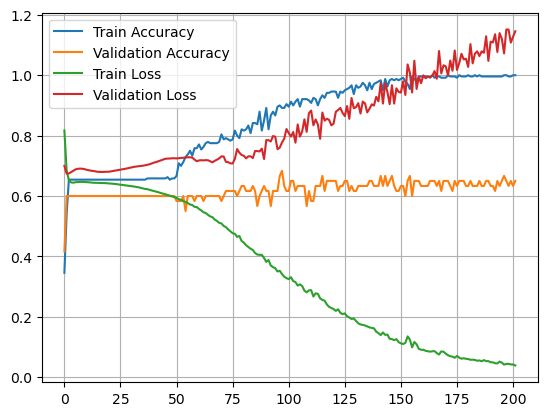

In [66]:
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.grid()

In [58]:
train_loss, train_acc = model.evaluate(X_train, y_train, batch_size=100)
train_loss, train_acc

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6733 - loss: 0.6500


(0.6561042070388794, 0.6541666388511658)

In [59]:
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=100)
test_loss, test_acc

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6000 - loss: 0.6744


(0.6744025945663452, 0.6000000238418579)

In [60]:
results["Neural Network"] = test_acc

In [61]:
y_predict = model.predict(X_test, batch_size=100)
y_pred = np.round(y_predict)
y_predict

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


array([[0.577989  ],
       [0.578418  ],
       [0.5798104 ],
       [0.5796893 ],
       [0.580505  ],
       [0.5808691 ],
       [0.57995903],
       [0.57492995],
       [0.58209825],
       [0.57507616],
       [0.5733715 ],
       [0.58503175],
       [0.5709346 ],
       [0.57906777],
       [0.5800672 ],
       [0.57786286],
       [0.58235466],
       [0.58091426],
       [0.58289945],
       [0.57849467],
       [0.5742786 ],
       [0.5797016 ],
       [0.5811957 ],
       [0.5815432 ],
       [0.58051366],
       [0.5808642 ],
       [0.582423  ],
       [0.5793023 ],
       [0.57687443],
       [0.57156867],
       [0.5796789 ],
       [0.57986116],
       [0.5766823 ],
       [0.578098  ],
       [0.578024  ],
       [0.5788682 ],
       [0.58002406],
       [0.57694757],
       [0.5782386 ],
       [0.5784987 ],
       [0.5763451 ],
       [0.5763875 ],
       [0.58347225],
       [0.5811221 ],
       [0.5721977 ],
       [0.58233607],
       [0.5815934 ],
       [0.576

In [62]:
y_pred = np.round(y_predict)

In [63]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test, y_pred)
matrix

array([[ 0, 24],
       [ 0, 36]], dtype=int64)

Text(0.5, 1.0, 'Confusion atrix')

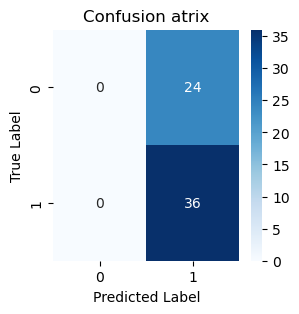

In [64]:
plt.figure(figsize=(3,3))
sns.heatmap(matrix,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=range(2),
            yticklabels=range(2),
           )
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion atrix")

## XGBoost

In [42]:
model = xgb.XGBClassifier()

In [43]:
parameters = {'n_estimators' :[19, 30, 40, 90, 150],
              'max_depth':[2, 4, 6, 8, 10, 12, 30],
              'subsample': [0.75, 1],
              'colsample_bytree' : [0.5, 0.75],
              'tree_method' : ['hist'],
              #'device' : ['cuda']
             }
grid = GridSearchCV(model, parameters)

In [44]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.5, 0.75],
                         'max_depth': [2, 4, 6, 8, 10, 12, 30],
                         'n_estimators': [19, 30, 40, 90, 150],
                         'subsample': [0.75, 1], 'tree_method': ['hist']})

In [45]:
print("Best CV params", grid.best_params_)
print("Best CV accuracy", grid.best_score_)
print("Test accuracy of best grid search hypers:", grid.score(X_test, y_test))

Best CV params {'colsample_bytree': 0.75, 'max_depth': 6, 'n_estimators': 40, 'subsample': 0.75, 'tree_method': 'hist'}
Best CV accuracy 0.6708333333333333
Test accuracy of best grid search hypers: 0.5333333333333333


In [46]:
results["XGBoost"] = grid.score(X_test, y_test)

## LightGBM

In [47]:
model = lgb.LGBMClassifier()

In [48]:
parameters = {'n_estimators' :[19, 30, 40, 90, 150],
              'max_depth':[2, 4, 6, 8, 10, 12, 30],
              'subsample': [0.75, 1],
              'num_leaves' : [20, 30, 40],
              #'tree_method' : ['hist'],
              #'device' : ['cuda']
             }
grid = GridSearchCV(model, parameters)

In [49]:
grid.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 125, number of negative: 67
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5907
[LightGBM] [Info] Number of data points in the train set: 192, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.651042 -> initscore=0.623621
[LightGBM] [Info] Start training from score 0.623621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 30],
                         'n_estimators': [19, 30, 40, 90, 150],
                         'num_leaves': [20, 30, 40], 'subsample': [0.75, 1]})

In [50]:
print("Best CV params", grid.best_params_)
print("Best CV accuracy", grid.best_score_)
print("Test accuracy of best grid search hypers:", grid.score(X_test, y_test))

Best CV params {'max_depth': 2, 'n_estimators': 30, 'num_leaves': 20, 'subsample': 0.75}
Best CV accuracy 0.6875
Test accuracy of best grid search hypers: 0.6166666666666667


In [51]:
results["LightGBM"] = grid.score(X_test, y_test)

## Results

In [67]:
results

{'Logistic Regression': 0.5333333333333333,
 'SVM': 0.5833333333333334,
 'Decision Tree': 0.6,
 'Neural Network': 0.6000000238418579,
 'XGBoost': 0.5333333333333333,
 'LightGBM': 0.6166666666666667}